# Import libararies

- Project & Code reference: https://github.com/nicknochnack/ActionDetectionforSignLanguage
- Version note: for mac users, the following libararies work under python 3.7 env

In [1]:
import mediapipe as mp
import os
import time
import numpy as np
import cv2
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

2024-01-09 13:51:59.762867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create mediapipe work flow

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [3]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [4]:
mp_holistic = mp.solutions.holistic # Define holistic model for detection
mp_drawing = mp.solutions.drawing_utils # Drawing utils

In [7]:
cap = cv2.VideoCapture(0) # Define the camera input

with mp_holistic.Holistic(min_tracking_confidence=.5, min_detection_confidence=.5) as holistic:
    while cap.isOpened():
        # create frame instance from the video stream
        ret, frame = cap.read()

        # put each frame into the model for detection
        image, results = mediapipe_detection(frame, holistic)

        # draw landmarks on the image
        draw_landmarks(image, results)
        
        # visualize results
        cv2.imshow('feed',image)

        # break the loop if press 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

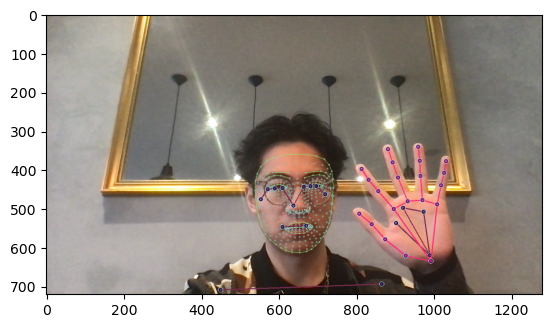

In [6]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Covert landmarks into arrays

In [5]:
# reference landmark shapes
# pose landmarks = 33 * (x, y, z, visibility) = 33 * 4
# face landmarks = 468 * (x, , y, z) = 468 * 3
# left hand landmarks = 21 * (x, y, z) = 21 * 3
# right hand landmarks = 21 * (x, y, z) = 21 * 3

# final array shape = (33 * 4 + 468 * 3 + 21 * 3 * 2) = (1662,)

# extracting pose, face, lefthand, righthand landmarks for LSTM training
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh])

# Capture realtime video datasets
- 30 sequences (videos)
- 30 frames (each video has 30 frams)
- 3 actions:
  - iloveyou
  - hello
  - thanks

In [7]:
# hyper_parameters
no_sequences = 30
no_frames = 30
actions = np.array(['iloveyou','hello','thanks'])

# create folders for captured frames
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join('actioncap',action,str(sequence)))
        except:
            pass

# Action Collection

In [32]:
cap = cv2.VideoCapture(0) # Define the camera input

with mp_holistic.Holistic(min_tracking_confidence=.5, min_detection_confidence=.5) as holistic:
    # loop through actions, folders
    for action in actions:
        for sequence_num in range(no_sequences):
            for frame_num in range(no_frames):
                # create frame instance from the video stream
                ret, frame = cap.read()
        
                # put each frame into the model for detection
                image, results = mediapipe_detection(frame, holistic)
        
                # draw landmarks on the image
                draw_landmarks(image, results)
        
                # apply waiting logic
                if frame_num == 0: 
                            cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255, 0), 4, cv2.LINE_AA)
                            cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence_num), (15,12), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
                            # Show to screen
                            cv2.imshow('OpenCV Feed', image)
                            cv2.waitKey(1300)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence_num), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    
                # extract actions and store into folders
                keypoints = extract_keypoints(results)
                array_path = os.path.join('actioncap', action, str(sequence_num), str(frame_num))
                np.save(array_path, keypoints)
        
                # break the loop if press 'q'
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                        
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

# Load recorded actions into mapped dataset

In [8]:
# label map
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

# load actions to dataset
sequences, labels = [],[]
for action in actions:
    for sequence_num in range(no_sequences):
        # temp list to store each frame
        window = []
        for frame_num in range(no_frames):
            load_path = os.path.join('actioncap', action, str(sequence_num), str(frame_num) + '.npy')
            temp = np.load(load_path)
            # append each temp frame into the window
            window.append(temp)
        # append each window into the final sequences, actions labels into labels
        sequences.append(window)
        labels.append(label_map[action])   
        
# Note:
# print out sequences shape and labels shape 
# sequences.shape:
# - total sequences = 30*3
# - 1 sequences has 30 frams
# - 1 frame has 1622 flatted landmark )
# labels.shape:
# - each sequence has 1 label, 30*3 sequences has 90 labels

print(np.array((sequences)).shape, np.array((labels)).shape)

{'iloveyou': 0, 'hello': 1, 'thanks': 2}
(90, 30, 1662) (90,)


In [9]:
# train test split
x = np.array(sequences)
y = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

# Build model

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras

In [11]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [23]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
del model

In [24]:
model.fit(X_train, y_train, epochs=200, callbacks=tb_callback)

Epoch 1/200
3/3 [==============================] - 3s 59ms/step - loss: 1.0998 - categorical_accuracy: 0.3882
Epoch 2/200
3/3 [==============================] - 0s 55ms/step - loss: 1.0888 - categorical_accuracy: 0.3412
Epoch 3/200
3/3 [==============================] - 0s 57ms/step - loss: 1.0801 - categorical_accuracy: 0.4706
Epoch 4/200
3/3 [==============================] - 0s 64ms/step - loss: 1.0732 - categorical_accuracy: 0.4000
Epoch 5/200
3/3 [==============================] - 0s 76ms/step - loss: 1.0447 - categorical_accuracy: 0.5647
Epoch 6/200
3/3 [==============================] - 0s 56ms/step - loss: 0.9950 - categorical_accuracy: 0.6353
Epoch 7/200
3/3 [==============================] - 0s 56ms/step - loss: 0.9143 - categorical_accuracy: 0.6588
Epoch 8/200
3/3 [==============================] - 0s 56ms/step - loss: 0.8247 - categorical_accuracy: 0.6588
Epoch 9/200
3/3 [==============================] - 0s 55ms/step - loss: 0.7241 - categorical_accuracy: 0.6706
Epoch 10/2

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# Test & Predictions

In [15]:
# Pass for this worksheet

In [20]:
model.save('action_recog.h5')

In [18]:
del model

In [29]:
model.load_weights('action_recog.h5')

# Real time testing

In [49]:
from scipy import stats

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [51]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [43]:
cap.release()
cv2.destroyAllWindows()